# Noise Estimation 

estimate noise type and distrubution with following techniques:
1. Image histogram 
2. Kolmogorov-Smirnov test
3. Frequency-domain analysis

In [10]:
# import liberies


import numpy as np
import matplotlib.pyplot as plt

import h5py


from scipy import stats

import sys
sys.path.append('../')

from module.datasets import load_4d_dicom
from module.utils import display_image_in_detail, calculate_metrics

## load estimate image(s)

In [3]:
## load preprocessed .h5 file 

with h5py.File('../dataset/preprocessed/PT_20p 150_120 OSEM_gauss_0.009.h5', 'r') as f:
    evl_data = f['dataset'][...]
    restore_info = f['restore_info'][...]


# denormalized 
print(restore_info)

mean_val = 201.12048776036573
std_val = 1412.4139804758772
max_val = 23.05689405684542
min_val = -23.34168377224119


evl_data = evl_data * (max_val - min_val) + min_val
evl_data = evl_data * std_val + mean_val

evl_data = np.clip(evl_data, np.iinfo(np.int16).min, np.iinfo(np.int16).max).astype(np.int16)

print(f"evl_data: {evl_data.dtype} shape: {evl_data.shape}; range({np.min(evl_data)}, {np.max(evl_data)}); mean:{np.mean(evl_data)}; std:{np.std(evl_data)}")

b'{"mean": 201.12048776036573, "std": 1412.4139804758772, "min": -23.34168377224119, "max": 23.05689405684542}'
evl_data: int16 shape: (24, 71, 192, 192); range(-32768, 32767); mean:200.9238672072401; std:1530.3175702236847


In [ ]:
## load data from dicom folder 

evl_data_folder = "../dataset/denoised/BM4D/PT_20p 150_120 OSEM_gauss_0.009/"

evl_data = load_4d_dicom(evl_data_folder)

print(f"evl_data: {evl_data.dtype} shape:{evl_data.shape} range({np.min(evl_data)}, {np.max(evl_data)}); mean:{np.mean(evl_data)}; std:{np.std(evl_data)}")

## 1. Image Histogram and Theoretical Distributions

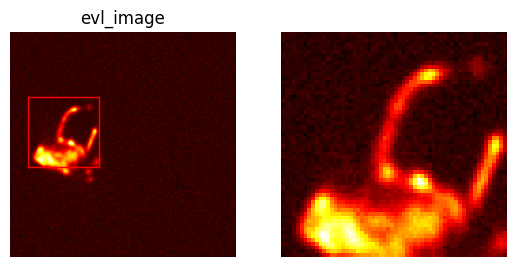

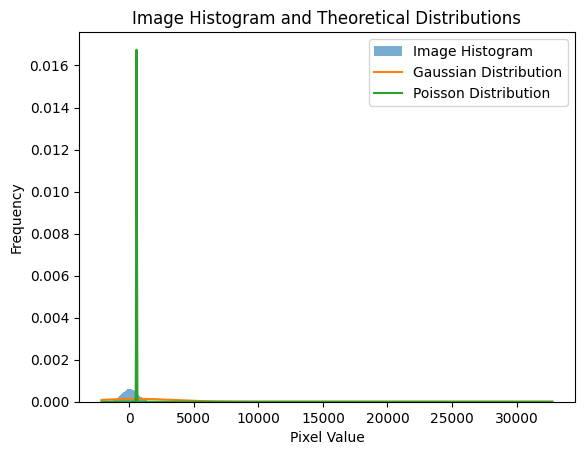

In [23]:
%matplotlib inline
evl_image = evl_data[11, 38]

display_image_in_detail(evl_image, title="evl_image")


image_data = evl_image.ravel()


# plot image histogram 
plt.hist(image_data, bins=500, density=True, alpha=0.6, label='Image Histogram')

# plt gaussian distribute 
# calculate gaussian distrubution parameters
mean, std_dev = np.mean(image_data), np.std(image_data)
x = np.linspace(min(image_data), max(image_data), 1000)
y = stats.norm.pdf(x, mean, std_dev)
plt.plot(x, y, label='Gaussian Distribution')

# plt poisson distribute 
# calcualte poisson distribution parameters
lambda_val = mean
y_poisson = stats.poisson.pmf(np.arange(min(image_data), max(image_data)+1), lambda_val)
plt.plot(np.arange(min(image_data), max(image_data)+1), y_poisson, label='Poisson Distribution')


# x y axix limitation
#plt.xlim([0, 500])  # 设置x轴的范围
# plt.ylim([lower_y_limit, upper_y_limit])  

plt.title('Image Histogram and Theoretical Distributions')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## 2. Kolmogorov-Smirnov test

The Kolmogorov-Smirnov (KS) test is a non-parametric test used to compare two probability distributions. The KS Statistic is a value calculated in the test that quantifies the difference between the two distributions. The larger the KS Statistic, the greater the difference between the distributions. Conversely, **if the KS Statistic is close to 0**, it indicates that the sample distribution is very close to the theoretical distribution.

In [13]:
def test_distribution(image_data, dist_name, dist_args):
    # Perform the Kolmogorov-Smirnov test
    ks_statistic, p_value = stats.kstest(image_data, dist_name, args=dist_args)
    print(f'{dist_name.capitalize()} Distribution: KS Statistic = {ks_statistic}, p-value = {p_value}')
    if p_value > 0.05:
        print(f'The sample distribution does not significantly differ from the {dist_name} distribution')
    else:
        print(f'The sample distribution significantly differs from the {dist_name} distribution')
    print()

In [25]:
# reavel 2D image 
image_data = evl_image.ravel()


# Estimate normal distribution
mean, std_dev = np.mean(image_data), np.std(image_data)
test_distribution(image_data, 'norm', (mean, std_dev))


# Estimate Poisson distribution
lambda_val = np.mean(image_data)
test_distribution(image_data, 'poisson', (lambda_val,))


# Estimate uniform distribution
min_val, max_val = np.min(image_data), np.max(image_data)
test_distribution(image_data, 'uniform', (min_val, max_val))


# Estimate exponential distrubution
lambda_expon = 1 / np.mean(image_data)
test_distribution(image_data, 'expon', (0, 1/lambda_expon))

# Estimate lognorm distribution
s_lognorm = np.std(np.log(image_data))  # scale parameter
test_distribution(image_data, 'lognorm', (s_lognorm,))

# Estimate gamma distribution
k_gamma, loc_gamma, theta_gamma = stats.gamma.fit(image_data)
test_distribution(image_data, 'gamma', (k_gamma, 0, theta_gamma))

# plt.hist(image_data, bins=50, density=True)
# plt.title('Image Histogram')
# plt.xlabel('Pixel Value')
# plt.ylabel('Frequency')
# plt.show()

Norm Distribution: KS Statistic = 0.3401384106648657, p-value = 0.0
The sample distribution significantly differs from the norm distribution

Poisson Distribution: KS Statistic = 0.7395373082679492, p-value = 0.0
The sample distribution significantly differs from the poisson distribution

Uniform Distribution: KS Statistic = 1.0, p-value = 0.0
The sample distribution significantly differs from the uniform distribution

Expon Distribution: KS Statistic = 0.4550238715277778, p-value = 0.0
The sample distribution significantly differs from the expon distribution

Lognorm Distribution: KS Statistic = nan, p-value = nan
The sample distribution significantly differs from the lognorm distribution



C:\Users\box69\AppData\Local\Temp\ipykernel_31636\757463661.py:25: RuntimeWarning: divide by zero encountered in log
  s_lognorm = np.std(np.log(image_data))  # scale parameter
C:\Users\box69\AppData\Local\Temp\ipykernel_31636\757463661.py:25: RuntimeWarning: invalid value encountered in log
  s_lognorm = np.std(np.log(image_data))  # scale parameter
d:\cardiac-dynamic-pet-denoising\.env\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2709: RuntimeWarning: overflow encountered in scalar subtract
  data_width = data_b - data_a


Gamma Distribution: KS Statistic = 0.9587686596349566, p-value = 0.0
The sample distribution significantly differs from the gamma distribution



## 3. Frequency-domain analysis

Magnitude Spectrum represents the intensity of each frequency component in the image

here are key features we might found from a image:
1. **Low-Frequency Components**: In the center of the magnitude spectrum, you'll find the low-frequency components of the image. These typically correspond to the gross structure and large areas of color variations within the image. Usually, most of the energy of an image resides in the low-frequency information.
2. **High-Frequency Components**: Towards the edges of the magnitude spectrum, you'll encounter the high-frequency components of the image. These correspond to details in the image and rapid color/brightness changes, such as edges and detailed textures. Noise often also appears within high-frequency components.
3. **Noise Characteristics**: If certain types of noise are present in the image, they may form specific patterns in the magnitude spectrum. For instance, high-frequency noise might enhance the outer part of the spectrum. **Salt-and-pepper noise**, characterized by sharp and sudden disturbances in the image, could also be reflected in sporadic spikes in the magnitude spectrum. **Gaussian noise** might create a more diffuse and spread-out effect, potentially overlapping with other frequency components. **Poission noise** might not as easy to identify as some other noise types since it is strong signal dependent.
4. **Periodic Patterns**: If there are periodic patterns or repeated textures in the image, these may form distinct spikes in the magnitude spectrum. These spikes correspond to specific frequencies of the periodic patterns.
5. **Filtering Effects**: If you have applied certain filters in the frequency domain (such as a low-pass filter), you might see the effects of these filters in the magnitude spectrum. For example, a low-pass filter might suppress the peripheral part of the spectrum, reducing the high-frequency components.


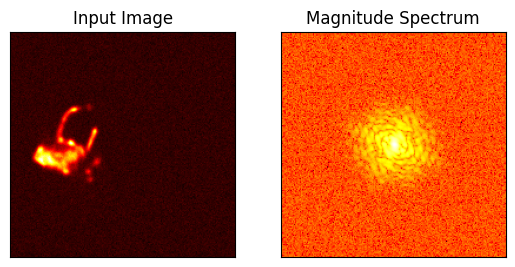

In [28]:
f_transform = np.fft.fft2(evl_image)
f_transform_shifted = np.fft.fftshift(f_transform)

# 计算幅度谱
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

# 显示结果
plt.subplot(121),plt.imshow(evl_image, cmap='hot')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(magnitude_spectrum, cmap='hot')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()